In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder,StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score,auc
from lightgbm import LGBMClassifier


In [2]:
train_data = pd.read_csv('../input/janatahack-crosssell-prediction-dataset/train.csv',index_col = 'id')
test_data = pd.read_csv('../input/janatahack-crosssell-prediction-dataset/test.csv',index_col = 'id')
combined = [train_data,test_data]

In [3]:
train_data.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
train_data.isnull().sum()

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127037 entries, 381110 to 508146
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                127037 non-null  object 
 1   Age                   127037 non-null  int64  
 2   Driving_License       127037 non-null  int64  
 3   Region_Code           127037 non-null  float64
 4   Previously_Insured    127037 non-null  int64  
 5   Vehicle_Age           127037 non-null  object 
 6   Vehicle_Damage        127037 non-null  object 
 7   Annual_Premium        127037 non-null  float64
 8   Policy_Sales_Channel  127037 non-null  float64
 9   Vintage               127037 non-null  int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 10.7+ MB


In [6]:
train_data.describe()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


In [7]:
cat_features = train_data.select_dtypes(['object']).columns
cat_features

Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')

In [8]:
for col in cat_features:
    print(train_data[col].nunique())

2
3
2


In [9]:
le = LabelEncoder()
for col in cat_features:
    train_data[col] = le.fit_transform(train_data[col])
    test_data[col] = le.fit_transform(test_data[col])

In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 381109 entries, 1 to 381109
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  float64
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  float64
 9   Vintage               381109 non-null  int64  
 10  Response              381109 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 34.9 MB


In [11]:
train_data.describe()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,0.540761,38.822584,0.997869,26.388807,0.458210,0.516388,0.504877,30564.389581,112.034295,154.347397,0.122563
std,0.498336,15.511611,0.046110,13.229888,0.498251,0.577698,0.499977,17213.155057,54.203995,83.671304,0.327936
min,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,0.000000,25.000000,1.000000,15.000000,0.000000,0.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,1.000000,36.000000,1.000000,28.000000,0.000000,0.000000,1.000000,31669.000000,133.000000,154.000000,0.000000
75%,1.000000,49.000000,1.000000,35.000000,1.000000,1.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,1.000000,85.000000,1.000000,52.000000,1.000000,2.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


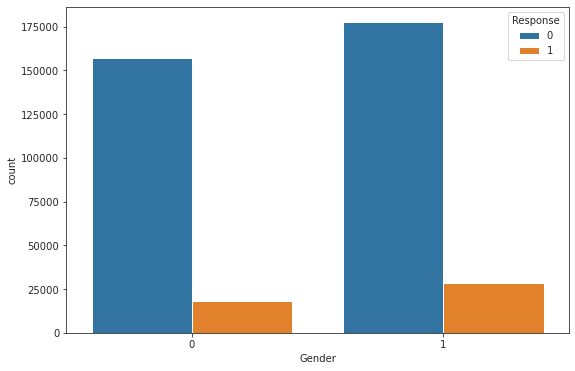

In [12]:
plt.figure(figsize = (9,6))
sns.set_style('ticks')
sns.countplot('Gender', hue = 'Response',data = train_data)
plt.show()

In [13]:
train_data['Age'].nunique()

66

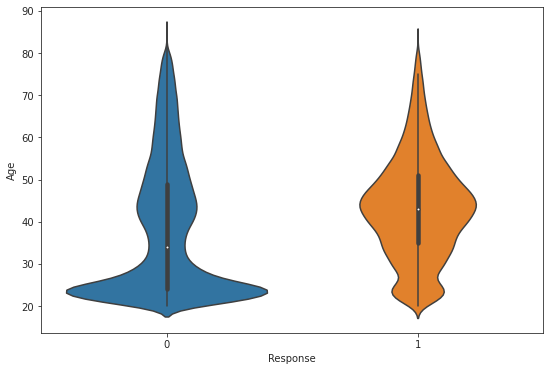

In [14]:
plt.figure(figsize = (9,6))
sns.set_style('ticks')
sns.violinplot('Response', 'Age',data = train_data)
plt.show()

In [15]:
sc = StandardScaler()
col = 'Age'
train_data[col] = sc.fit_transform(train_data[col].values.reshape(-1,1))
test_data[col] = sc.transform(test_data[col].values.reshape(-1,1))

In [16]:
train_data['Driving_License'].nunique()

2

In [17]:
train_data[train_data['Driving_License'] == 1]['Response'].count()

380297

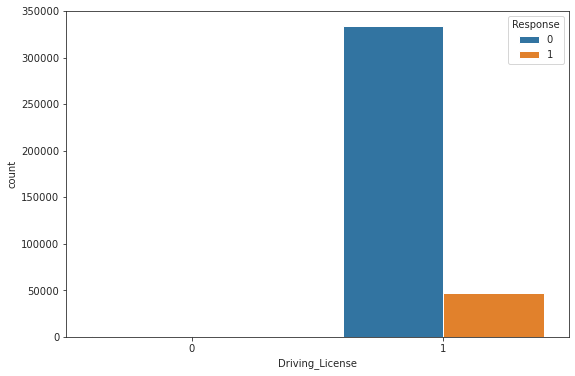

In [18]:
plt.figure(figsize = (9,6))
sns.set_style('ticks')
sns.countplot('Driving_License', hue = 'Response',data = train_data)
plt.show()

In [19]:
train_data['Region_Code'].nunique()

53

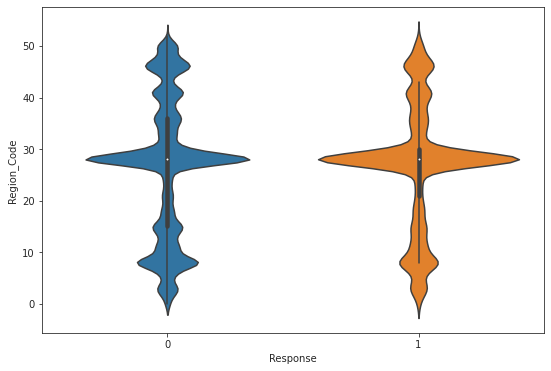

In [20]:
plt.figure(figsize = (9,6))
sns.set_style('ticks')
sns.violinplot('Response', 'Region_Code',data = train_data)
plt.show()

In [21]:
train_data['Previously_Insured'].nunique()

2

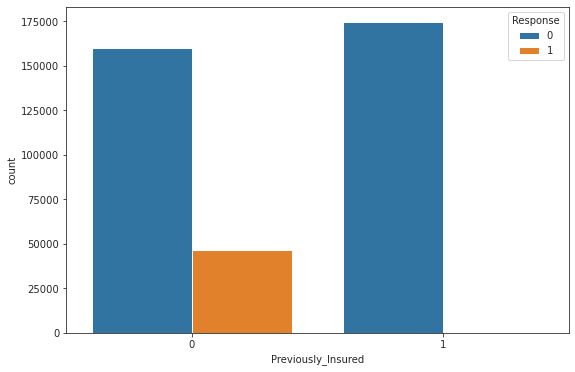

In [22]:
plt.figure(figsize = (9,6))
sns.set_style('ticks')
sns.countplot('Previously_Insured', hue = 'Response',data = train_data)
plt.show()

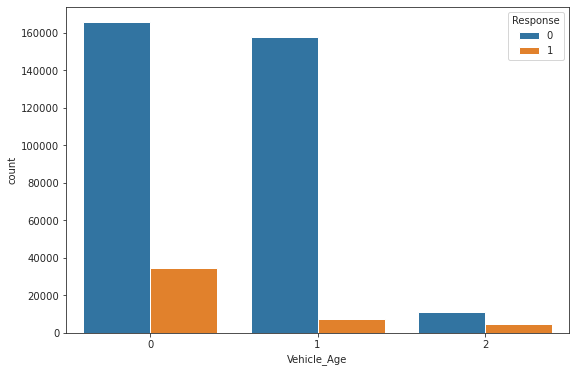

In [23]:
plt.figure(figsize = (9,6))
sns.set_style('ticks')
sns.countplot('Vehicle_Age', hue = 'Response',data = train_data)
plt.show()

In [24]:
train_data['Vehicle_Damage'].nunique()

2

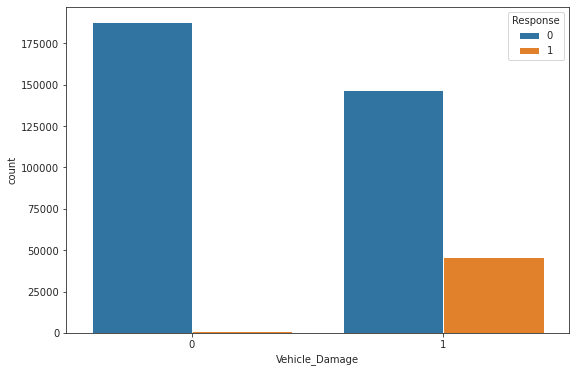

In [25]:
plt.figure(figsize = (9,6))
sns.set_style('ticks')
sns.countplot('Vehicle_Damage', hue = 'Response',data = train_data)
plt.show()

In [26]:
train_data['Annual_Premium'].nunique()

48838

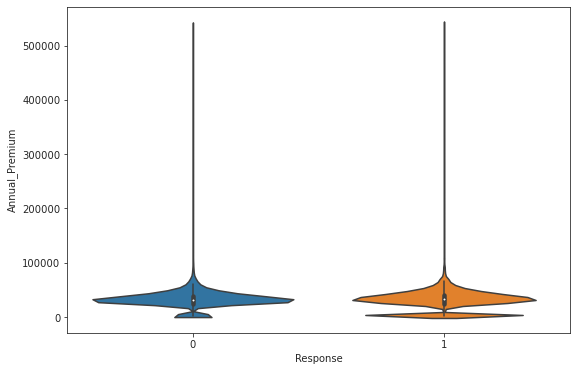

In [27]:
plt.figure(figsize = (9,6))
sns.set_style('ticks')
sns.violinplot('Response', 'Annual_Premium',data = train_data)
plt.show()

In [28]:
# dataset = train_data
# index = dataset[dataset['Annual_Premium'] >= 115000]['Annual_Premium'].index.values
# dataset.drop(index,inplace = True)

In [29]:
sc = StandardScaler()
col = 'Annual_Premium'
train_data[col] = sc.fit_transform(train_data[col].values.reshape(-1,1))
test_data[col] = sc.transform(test_data[col].values.reshape(-1,1))

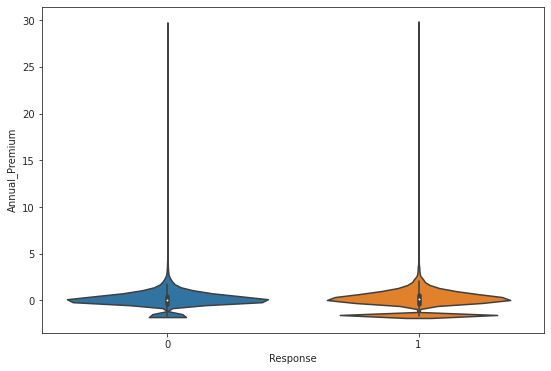

In [30]:
plt.figure(figsize = (9,6))
sns.set_style('ticks')
sns.violinplot('Response', 'Annual_Premium',data = train_data)
plt.show()

In [31]:
train_data['Policy_Sales_Channel'].nunique()

155

In [32]:
mms = MinMaxScaler()
col = 'Policy_Sales_Channel'
train_data[col] = mms.fit_transform(train_data[col].values.reshape(-1,1))
test_data[col] = mms.transform(test_data[col].values.reshape(-1,1))

In [33]:
sc = StandardScaler()
col = 'Policy_Sales_Channel'
train_data[col] = sc.fit_transform(train_data[col].values.reshape(-1,1))
test_data[col] = sc.transform(test_data[col].values.reshape(-1,1))

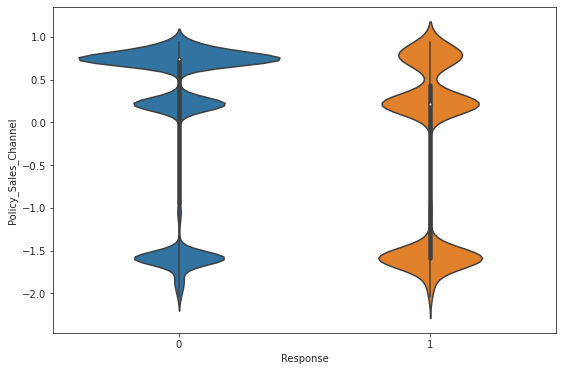

In [34]:
plt.figure(figsize = (9,6))
sns.set_style('ticks')
sns.violinplot('Response', 'Policy_Sales_Channel',data = train_data)
plt.show()

In [35]:
train_data['Vintage'].nunique()

290

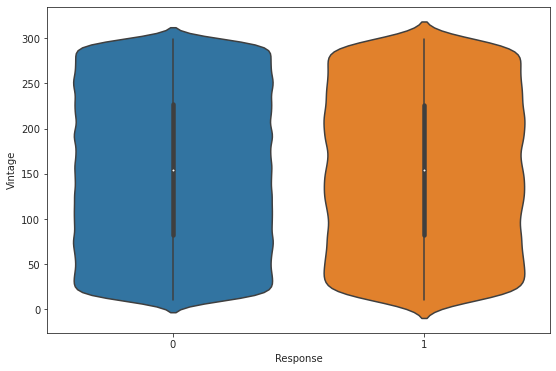

In [36]:
plt.figure(figsize = (9,6))
sns.set_style('ticks')
sns.violinplot('Response', 'Vintage',data = train_data)
plt.show()

In [37]:
train_data.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,1,0.333777,1,28.0,0,2,1,0.574539,-1.587234,217,1
2,1,2.396751,1,3.0,0,0,0,0.172636,-1.587234,183,0
3,1,0.527181,1,28.0,0,2,1,0.449053,-1.587234,27,1
4,1,-1.148985,1,11.0,1,1,0,-0.113018,0.737321,203,0
5,0,-0.633242,1,41.0,1,1,0,-0.178259,0.737321,39,0


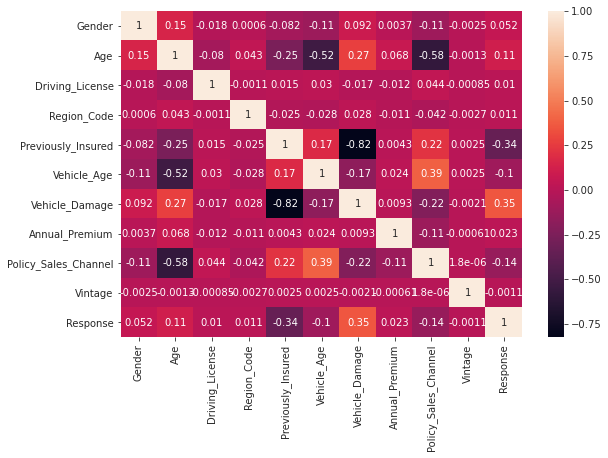

In [38]:
plt.figure(figsize = (9,6))
sns.heatmap(train_data.corr(),annot=True,cbar = True)
plt.show()

In [39]:
y = train_data.loc[:,'Response']
X = train_data.drop('Response',axis = 1)
X

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
id,,,,,,,,,,
1,1,0.333777,1,28.0,0,2,1,0.574539,-1.587234,217
2,1,2.396751,1,3.0,0,0,0,0.172636,-1.587234,183
3,1,0.527181,1,28.0,0,2,1,0.449053,-1.587234,27
4,1,-1.148985,1,11.0,1,1,0,-0.113018,0.737321,203
5,0,-0.633242,1,41.0,1,1,0,-0.178259,0.737321,39
...,...,...,...,...,...,...,...,...,...,...
381105,1,2.267815,1,26.0,1,0,0,-0.022912,-1.587234,88
381106,1,-0.568774,1,37.0,1,1,0,0.549093,0.737321,131
381107,1,-1.148985,1,30.0,1,1,0,0.264543,0.884912,161


In [40]:

x_train,x_val,y_train,y_val = train_test_split(X,y,test_size = 0.2,random_state = 42)


In [41]:
model = LGBMClassifier(boosting_type='gbdt',n_estimators=500,depth=10,learning_rate=0.04,objective='binary',metric='auc',is_unbalance=True,
                 colsample_bytree=0.5,reg_lambda=2,reg_alpha=2,random_state=294,n_jobs=-1)

clf = model.fit(x_train,y_train)

In [42]:
roc_auc_score(y_train,clf.predict(x_train))

0.8087433670124577

In [43]:
roc_auc_score(y_val,clf.predict_proba(x_val)[:,1])

0.8613259288241318

In [44]:
y_pred = clf.predict_proba(test_data)[:,1]

In [45]:
sub = pd.DataFrame(y_pred,columns = ['Response'],index = [i + 381110 for i in range(test_data.shape[0])])

sub.index.name = 'id'
sub.tail()

,Response
id,
508142,0.003194
508143,0.810238
508144,0.001612
508145,0.001292
508146,0.006927


In [46]:
sub.to_csv('sub.csv')